# 02 - Análisis Exploratorio de Datos (EDA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from matplotlib.colors import LogNorm # Para el gráfico de dispersión geo

sns.set_theme(style="whitegrid")

# Cargar los datos limpios del notebook 01
try:
    df = pd.read_csv('../data/processed/properati_clean.csv')
except FileNotFoundError:
    print("Error: 'properati_clean.csv' no encontrado. Ejecuta el notebook 01 primero.")
    df = pd.DataFrame()

## 1. Análisis de Variables Numéricas

In [2]:
print(df[['price', 'surface_total', 'surface_covered', 'rooms', 'bathrooms']].describe())

              price  surface_total  surface_covered       rooms    bathrooms
count  5.000000e+03    5000.000000      5000.000000  5000.00000  5000.000000
mean   1.808945e+05      81.688200        72.316600     2.50020     1.266600
std    1.466477e+05     696.068212       689.147448     0.50005     0.525718
min    1.000000e+04      10.000000        21.000000     2.00000     1.000000
25%    1.090000e+05      51.000000        46.000000     2.00000     1.000000
50%    1.490000e+05      60.000000        54.000000     3.00000     1.000000
75%    2.080000e+05      73.000000        64.000000     3.00000     1.000000
max    3.383000e+06   47360.000000     47360.000000     3.00000     6.000000


## 2. Análisis de Variables Categóricas

In [3]:
print("Tipo de Operación:")
print(df['operation_type'].value_counts())
print("\nTipo de Propiedad:")
print(df['property_type'].value_counts())
print("\nMoneda:")
print(df['currency'].value_counts())

Tipo de Operación:
operation_type
Venta    5000
Name: count, dtype: int64

Tipo de Propiedad:
property_type
Departamento    4486
PH               514
Name: count, dtype: int64

Moneda:
currency
USD    5000
Name: count, dtype: int64


## 3. (Modificado) Análisis Geoespacial de Precios (Ventas en USD)

Usamos un gráfico de dispersión de `lat` vs `lon` para visualizar la geografía de los datos.
Coloreamos por precio (en escala logarítmica) y filtramos outliers para centrarnos en el clúster principal.

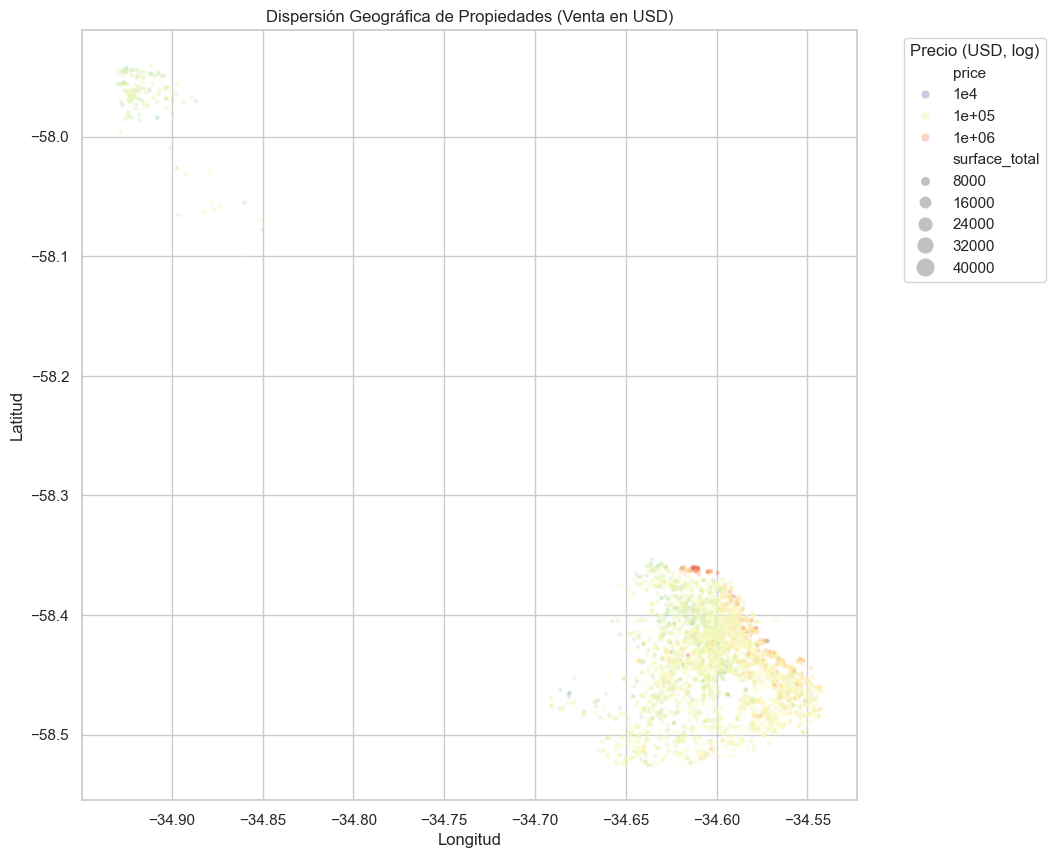

In [4]:
# Filtrar para un mapa coherente
df_ventas_usd = df[(df['operation_type'] == 'Venta') & (df['currency'] == 'USD')].copy()

# --- Filtro de Outliers Geoespaciales ---
# Calculamos los percentiles 1 y 99 para lat y lon para eliminar puntos muy lejanos
lat_min, lat_max = df_ventas_usd['lat'].quantile(0.01), df_ventas_usd['lat'].quantile(0.99)
lon_min, lon_max = df_ventas_usd['lon'].quantile(0.01), df_ventas_usd['lon'].quantile(0.99)

df_geo_filtered = df_ventas_usd[
    (df_ventas_usd['lat'] > lat_min) & (df_ventas_usd['lat'] < lat_max) &
    (df_ventas_usd['lon'] > lon_min) & (df_ventas_usd['lon'] < lon_max)
]
# --- Fin del Filtro ---

plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_geo_filtered.sample(min(10000, len(df_geo_filtered))), # Tomar una muestra
    x='lon',
    y='lat',
    hue='price',
    size='surface_total',
    hue_norm=LogNorm(), # Usar escala logarítmica para el color del precio
    palette='Spectral_r',
    alpha=0.3,
    sizes=(10, 200)
)
plt.title('Dispersión Geográfica de Propiedades (Venta en USD)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Precio (USD, log)', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

## 4. (Modificado) Análisis de Texto (Nube de Palabras con Stopwords)

Analizamos las palabras más comunes en la columna `title`, pero esta vez eliminando las palabras comunes y poco interesantes (stopwords) para ver los términos que realmente aportan valor.

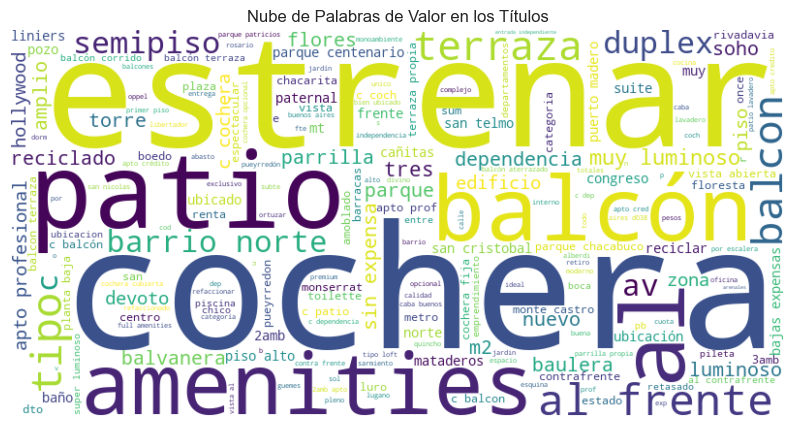

In [5]:
try:
    # Lista de palabras a ignorar
    STOPWORDS = [
        'de', 'la', 'en', 'el', 'y', 'a', 'con', 'para', 'los', 'del', 'las', 'un', 'una','depto','venta', 'alquiler', 'propiedad', 'propiedades', 'dos','departamento', 'casa', 'ph','ambientes', 'amb', 'ambiente', 'dormitorio', 'dormitorios', 'capital', 'federal','excelente', 'gran', 'buen', 'oportunidad', 'impecable', 'hermoso', 'lindo',
        'usd', 'ars', 'precio', 'valor', 'caballito','almagro','villa', 'crespo','palermo','recoleta','belgrano','urquiza','saavedra','colegiales','plata','dpto','nuñez', 'coghlan'
    ]

    text = " ".join(t for t in df.title.dropna().str.lower())
    
    wordcloud = WordCloud(
        stopwords=STOPWORDS,
        width=800, 
        height=400, 
        background_color="white",
        colormap='viridis'
    ).generate(text)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Nube de Palabras de Valor en los Títulos")
    plt.show()
except ImportError:
    print("Librería 'wordcloud' no instalada. Por favor, instálala (pip install wordcloud) para ver este gráfico.")
except Exception as e:
    print(f"Error al generar la nube de palabras: {e}")